/home/augustinm/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
No handles with labels found to put in legend.


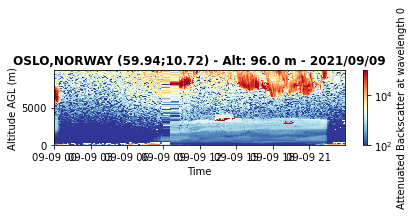

In [1]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

path = "data/e-profile/2021/09/08/L2_0-20000-006735_A20210908.nc"
path = "data/e-profile/2021/09/09/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

profiles.range_correction(inplace=True)
profiles.gaussian_filter(sigma=0.0, inplace=True)
profiles.quickplot(zmin=0, zmax=10000, vmin=1e2, vmax=1e5, log=True)

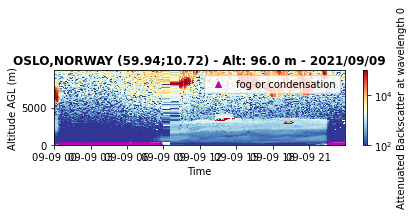

In [4]:
profiles.detect_fog_or_condensation(zmin=200).quickplot(zmin=0, zmax=10000, vmin=1e2, vmax=1e5, log=True, add_fog=True)